## This notebook was created to get accelerometer-replacement dataframes for the pupil state analysis - If needed, it could also be used for a rough location estimation paradigm (similar to yolo) and there's much to improve here still

In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


In [2]:
def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


In [3]:
import pandas as pd

def read_behavior_state(block):
    """
    Reads the behavior_state CSV file from the block's analysis folder and assigns it to the block object.

    Args:
        block (BlockSync): The block object containing metadata about the analysis folder.

    Returns:
        pd.DataFrame: The loaded behavior state dataframe.
    """
    try:
        # Construct the path to the CSV file
        csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
        
        if not csv_path.exists():
            raise FileNotFoundError(f"No behavior_state file found at {csv_path}")
        
        # Read the CSV into a DataFrame
        behavior_state_df = pd.read_csv(csv_path)
        
        # Assign it to the block object for easy access
        block.behavior_state = behavior_state_df
        print(f"Behavior state successfully loaded from {csv_path}")
        
        return behavior_state_df
    
    except Exception as e:
        print(f"Error reading behavior state: {e}")
        return None

def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))

def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices

def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    
def play_video_with_ellipses_rotation(block, eye, path_to_video=False, xflip=False, transformation_matrix=None, phi_in_radians=False):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        if transformation_matrix is not None:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
                
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue
        else:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
        
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def play_video_with_ellipses_rotation_plus_major_axis(block, eye, path_to_video=False, xflip=False, transformation_matrix=None):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['major_ax'])
            height = int(current_frame_data['minor_ax'])
            phi = np.deg2rad(float(current_frame_data['phi']))  # Convert angle to radians
            
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
            
            # Calculate endpoints of major axis
            axis_length = max(width, height) / 2
            sin_phi = np.sin(phi)
            cos_phi = np.cos(phi)
            x1 = int(center_x + axis_length * cos_phi)
            y1 = int(center_y + axis_length * sin_phi)
            x2 = int(center_x - axis_length * cos_phi)
            y2 = int(center_y - axis_length * sin_phi)
            
            # Draw major axis
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            
            # Add text to the frame
            text = f'ellipse angle: {np.rad2deg(phi)}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def get_frame_count(video_path):
        """
        Get the number of frames for the video in the specified path using OpenCV.
    
        Parameters:
            video_path (str): Path to the video file.
    
        Returns:
            int: Number of frames in the video.
        """
        
        # Open the video file
        cap = cv2.VideoCapture(video_path)
    
        # Check if the video file is opened successfully
        if not cap.isOpened():
            print("Error: Could not open the video file.")
            return -1
    
        # Get the total number of frames in the video
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        # Release the VideoCapture object
        cap.release()
    
        return frame_count


# Block Instantiation

In [17]:

# define a single block to synchronize and finally export l/r_eye_data csv files:
# this step creates block_collection - a list of BlockSync objects of interest

bad_blocks = [] # 
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
#animal = 'PV_62' || block_numbers = [23,24,25,26,27]
#animal = 'PV_126' # || block_numbers = [7,8,9,10,11,12,13,14] 
#animal = 'PV_24'  
animal = 'PV_57'
block_numbers = [12]
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks,regev=True)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block = block_collection[0]

instantiated block number 012 at Path: Z:\Nimrod\experiments\PV_57\2024_12_01\block_012, new OE version
Found the sample rate for block 012 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 012
got it!


In [18]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)
    block.handle_arena_files()
    
    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    #if 'pupil_diameter' not in block.left_eye_data.columns:
    block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
    block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 012 has a parsed events file, reading...
Getting eye brightness values for block 012...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
handling arena files
Arena video Names:
front_20241201T160900.mp4
left_20241201T160900.mp4
right_20241201T160900.mp4
top_20241201T160900.mp4
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


# Over here there's an attempt at getting automatic LED annotations for movement quantification\

In [19]:
# This one works
import cv2
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

def process_led_video_advanced(video_path, params=None, max_frames=None):
    """
    Process a video file containing 4 LED detections with improved candidate handling.
    
    Parameters:
      video_path (str): Path to the video file.
      params (dict, optional): Dictionary of detection parameters to override defaults.
         Expected keys:
           - brightness_thresh (default 200)
           - min_blob_area (default 5)
           - max_blob_area (default 500)
           - max_movement (default 50)
           - max_cluster_size (default 150)
           - expected_count (default 4)
      max_frames (int, optional): Process only the first X frames (useful for debugging).
    
    Returns:
      pd.DataFrame: DataFrame with columns:
        [frame, x1, y1, x2, y2, x3, y3, x4, y4, notes, problem]
      where the LED order is:
        - For 4 detections: left-top, left-bottom, right-top, right-bottom.
        - For fewer detections, available positions are filled in order and the rest are NaN.
    """
    # Set default parameters and update with any provided values
    default_params = {
        'brightness_thresh': 200,
        'min_blob_area': 5,
        'max_blob_area': 500,
        'max_movement': 50,
        'max_cluster_size': 150,
        'expected_count': 4,
    }
    if params:
        default_params.update(params)
    
    brightness_thresh = default_params['brightness_thresh']
    min_blob_area = default_params['min_blob_area']
    max_blob_area = default_params['max_blob_area']
    max_movement = default_params['max_movement']
    max_cluster_size = default_params['max_cluster_size']
    expected_count = default_params['expected_count']
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return None

    # Read the first frame for ROI selection
    ret, first_frame = cap.read()
    if not ret:
        print("Error reading the first frame.")
        cap.release()
        return None

    # Let user select ROI (press ENTER or SPACE when done)
    roi = cv2.selectROI("Select ROI (press ENTER/SPACE when done)", first_frame, showCrosshair=True)
    cv2.destroyWindow("Select ROI (press ENTER/SPACE when done)")
    # ROI format: (x, y, w, h)
    
    # Rewind video to beginning and get total frame count
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if max_frames is not None:
        total_frames = min(total_frames, max_frames)
    
    results = []  # Will hold rows: [frame, x1, y1, x2, y2, x3, y3, x4, y4, notes, problem]
    frame_number = 0
    prev_leds = None  # List of previous LED positions (length expected_count), with missing ones as None
    
    for _ in tqdm(range(total_frames), desc="Processing Frames", unit="frame"):
        ret, frame = cap.read()
        if not ret:
            break
        frame_number += 1

        # Convert to grayscale and threshold to get bright areas
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, brightness_thresh, 255, cv2.THRESH_BINARY)
        
        # Find contours in thresholded image
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Build candidate list (dictionary with 'centroid' and 'area')
        candidates_full = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < min_blob_area or area > max_blob_area:
                continue
            M = cv2.moments(cnt)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            candidates_full.append({"centroid": (cx, cy), "area": area})
        
        # Filter candidates inside ROI
        rx, ry, rw, rh = roi
        candidates_roi = [cand for cand in candidates_full if (rx <= cand["centroid"][0] <= rx+rw and ry <= cand["centroid"][1] <= ry+rh)]
        
        fallback_note = ""
        if len(candidates_roi) >= 2:
            candidates = candidates_roi
        else:
            candidates = candidates_full
            fallback_note = "ROI fallback; "
        
        # If still fewer than 2 candidates, we cannot reliably detect LEDs.
        if len(candidates) < 2:
            selected_leds = [np.nan] * expected_count
            notes = fallback_note + f"Not enough candidates: found {len(candidates)}"
            problem = True
        else:
            # --- Matching / Selection ---
            if prev_leds is None:
                # For first frame, choose candidates based on smallest area.
                sorted_cands = sorted(candidates, key=lambda d: d["area"])
                selected = [d["centroid"] for d in sorted_cands[:expected_count]]
            else:
                # Use previous detections to guide matching
                valid_prev = [pos for pos in prev_leds if pos is not None and not np.isnan(pos).any()]
                cand_positions = np.array([cand["centroid"] for cand in candidates])
                if len(valid_prev) > 0 and len(cand_positions) > 0:
                    prev_arr = np.array(valid_prev)
                    cost_matrix = np.linalg.norm(prev_arr[:, None, :] - cand_positions[None, :, :], axis=2)
                    row_ind, col_ind = linear_sum_assignment(cost_matrix)
                    matched = {}
                    used_cand = set()
                    for r, c in zip(row_ind, col_ind):
                        if cost_matrix[r, c] <= max_movement:
                            matched[tuple(valid_prev[r])] = tuple(cand_positions[c])
                            used_cand.add(c)
                    selected = []
                    for pos in prev_leds:
                        if pos is not None and (not np.isnan(pos).any()) and tuple(pos) in matched:
                            selected.append(matched[tuple(pos)])
                        else:
                            selected.append(None)
                    remaining_candidates = [tuple(cand_positions[i]) for i in range(len(cand_positions)) if i not in used_cand]
                    for i in range(len(selected)):
                        if selected[i] is None and remaining_candidates:
                            assigned = [p for p in selected if p is not None]
                            center = np.mean(np.array(assigned), axis=0) if assigned else np.array([frame.shape[1]//2, frame.shape[0]//2])
                            distances = [np.linalg.norm(np.array(c) - center) for c in remaining_candidates]
                            min_idx = np.argmin(distances)
                            if distances[min_idx] <= max_movement:
                                selected[i] = remaining_candidates[min_idx]
                                remaining_candidates.pop(min_idx)
                else:
                    sorted_cands = sorted(candidates, key=lambda d: d["area"])
                    selected = [d["centroid"] for d in sorted_cands[:expected_count]]
            
            if len(selected) < expected_count:
                selected.extend([None]*(expected_count - len(selected)))
            selected_leds = [tuple(s) if s is not None else np.nan for s in selected]
            
            # --- Ordering ---
            valid_positions = [s for s in selected_leds if not isinstance(s, float) and not (isinstance(s, np.ndarray) and np.isnan(s).all())]
            if len(valid_positions) == 4:
                sorted_by_x = sorted(selected_leds, key=lambda p: p[0] if not isinstance(p, float) else 1e6)
                left_cluster = sorted(sorted_by_x[:2], key=lambda p: p[1])
                right_cluster = sorted(sorted_by_x[2:], key=lambda p: p[1])
                selected_leds = left_cluster + right_cluster
            else:
                selected_leds = sorted(selected_leds, key=lambda p: p[0] if not isinstance(p, float) else 1e6)
            
            # --- Clustering Check ---
            valid_arr = np.array([p for p in selected_leds if not isinstance(p, float) and not (isinstance(p, np.ndarray) and np.isnan(p).all())])
            if valid_arr.size > 0:
                bbox_min = valid_arr.min(axis=0)
                bbox_max = valid_arr.max(axis=0)
                bbox_size = bbox_max - bbox_min
            else:
                bbox_size = np.array([0, 0])
            
            notes = fallback_note
            if len(valid_positions) < expected_count:
                notes += f"Only {len(valid_positions)} detections; "
                problem = True
            else:
                problem = False
            if bbox_size[0] > max_cluster_size or bbox_size[1] > max_cluster_size:
                notes += f"Cluster size too large: {bbox_size}; "
                problem = True

        # Unpack detections for output
        def unpack(idx):
            if len(selected_leds) > idx and isinstance(selected_leds[idx], tuple):
                return selected_leds[idx]
            return (np.nan, np.nan)
        
        (x1, y1) = unpack(0)
        (x2, y2) = unpack(1)
        (x3, y3) = unpack(2)
        (x4, y4) = unpack(3)
        
        results.append([frame_number, x1, y1, x2, y2, x3, y3, x4, y4, notes, problem])
        
        # Update previous detections
        updated_prev = []
        for val in selected_leds:
            if isinstance(val, tuple):
                updated_prev.append(val)
            else:
                updated_prev.append(None)
        prev_leds = updated_prev

    cap.release()
    df = pd.DataFrame(results, columns=["frame", "x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "notes", "problem"])
    return df


def tune_detection_parameters(video_path):
    """
    Open an OpenCV GUI with sliders to tune detection parameters.
    The function displays the first frame of the video (with ROI selected)
    and overlays candidate detections based on the current slider settings.
    
    Returns:
      dict: A dictionary of parameter values to be passed to process_led_video_advanced().
            Keys: 'brightness_thresh', 'min_blob_area', 'max_blob_area',
                  'max_movement', 'max_cluster_size', 'expected_count'
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return None

    ret, frame = cap.read()
    if not ret:
        print("Error reading the first frame.")
        cap.release()
        return None

    # Let user select ROI
    roi = cv2.selectROI("Select ROI", frame, showCrosshair=True)
    cv2.destroyWindow("Select ROI")
    rx, ry, rw, rh = roi

    def nothing(x):
        pass

    cv2.namedWindow("Parameter Tuning", cv2.WINDOW_NORMAL)

    # Initial default values
    init_params = {
        "brightness_thresh": 230,
        "min_blob_area": 5,
        "max_blob_area": 70,
        "max_movement": 25,
        "max_cluster_size": 150,
        "expected_count": 4
    }

    # Create trackbars for each parameter
    cv2.createTrackbar("Brightness Thresh", "Parameter Tuning", init_params["brightness_thresh"], 255, nothing)
    cv2.createTrackbar("Min Blob Area", "Parameter Tuning", init_params["min_blob_area"], 1000, nothing)
    cv2.createTrackbar("Max Blob Area", "Parameter Tuning", init_params["max_blob_area"], 1000, nothing)
    cv2.createTrackbar("Max Movement", "Parameter Tuning", init_params["max_movement"], 100, nothing)
    cv2.createTrackbar("Max Cluster Size", "Parameter Tuning", init_params["max_cluster_size"], 300, nothing)
    cv2.createTrackbar("Expected Count", "Parameter Tuning", init_params["expected_count"], 10, nothing)

    while True:
        # Read current slider positions
        brightness_thresh = cv2.getTrackbarPos("Brightness Thresh", "Parameter Tuning")
        min_blob_area = cv2.getTrackbarPos("Min Blob Area", "Parameter Tuning")
        max_blob_area = cv2.getTrackbarPos("Max Blob Area", "Parameter Tuning")
        max_movement = cv2.getTrackbarPos("Max Movement", "Parameter Tuning")
        max_cluster_size = cv2.getTrackbarPos("Max Cluster Size", "Parameter Tuning")
        expected_count = cv2.getTrackbarPos("Expected Count", "Parameter Tuning")

        # Process the first frame using current parameters
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh_img = cv2.threshold(gray, brightness_thresh, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        candidates = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < min_blob_area or area > max_blob_area:
                continue
            M = cv2.moments(cnt)
            if M["m00"] == 0:
                continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            if rx <= cx <= rx+rw and ry <= cy <= ry+rh:
                candidates.append((cx, cy))

        preview = frame.copy()
        cv2.rectangle(preview, (rx, ry), (rx+rw, ry+rh), (0, 255, 0), 2)
        for (cx, cy) in candidates:
            cv2.circle(preview, (cx, cy), 5, (0, 0, 255), -1)

        info_text = (f"Brightness: {brightness_thresh} | MinArea: {min_blob_area} | "
                     f"MaxArea: {max_blob_area} | MaxMove: {max_movement} | "
                     f"MaxCluster: {max_cluster_size} | Expected: {expected_count}")
        cv2.putText(preview, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (255, 255, 255), 2)

        cv2.imshow("Parameter Tuning", preview)
        cv2.imshow("Threshold", thresh_img)

        key = cv2.waitKey(1) & 0xFF
        # Press 'q' to quit and output the parameter dictionary
        if key == ord('q'):
            break

    # Gather the final parameter values into a dictionary
    final_params = {
        "brightness_thresh": cv2.getTrackbarPos("Brightness Thresh", "Parameter Tuning"),
        "min_blob_area": cv2.getTrackbarPos("Min Blob Area", "Parameter Tuning"),
        "max_blob_area": cv2.getTrackbarPos("Max Blob Area", "Parameter Tuning"),
        "max_movement": cv2.getTrackbarPos("Max Movement", "Parameter Tuning"),
        "max_cluster_size": cv2.getTrackbarPos("Max Cluster Size", "Parameter Tuning"),
        "expected_count": cv2.getTrackbarPos("Expected Count", "Parameter Tuning")
    }

    cap.release()
    cv2.destroyAllWindows()
    return final_params


params = tune_detection_parameters(str(block.arena_videos[-1]))



In [20]:
# second stage is analyzing the video
df_results = process_led_video_advanced(str(block.arena_videos[-1]))

Processing Frames: 100%|██████████| 83486/83486 [07:29<00:00, 185.68frame/s]


In [21]:
# third stage - perform filtering and process detections to produce head datapoints
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def smooth_segments(arr, sigma, max_gap=60):
    """
    Smooth an array with NaNs left intact except for short gaps.
    Gaps shorter than max_gap frames are linearly interpolated and then smoothed
    with a Gaussian filter on each contiguous (or bridged) segment.
    Longer gaps remain as NaN.
    """
    s = pd.Series(arr)
    s_interp = s.interpolate(method='linear', limit=max_gap-1, limit_direction='both')
    filled = s_interp.values
    out = np.copy(filled)
    n = len(arr)
    valid = ~np.isnan(filled)
    if not valid.any():
        return out

    segments = []
    seg_start = None
    for i in range(n):
        if valid[i]:
            if seg_start is None:
                seg_start = i
        else:
            if seg_start is not None:
                segments.append((seg_start, i))
                seg_start = None
    if seg_start is not None:
        segments.append((seg_start, n))
    
    for (start, end) in segments:
        out[start:end] = gaussian_filter1d(filled[start:end], sigma=sigma)
    
    original = s.values
    out[np.isnan(original)] = np.nan
    return out

def process_smoothed_path_data_from_df(df, sigma=5, jump_threshold=100):
    """
    Processes the LED detection data from the provided dataframe (df) without reading the video.
    Assumes df has:
      - 'frame' column (1-indexed frame numbers),
      - LED detection columns: 'x1', 'x2', 'x3', 'x4' and 'y1', 'y2', 'y3', 'y4',
      - 'notes' column with any initial detection comments.
    
    The function:
      1. Computes per-frame average (x,y) from the LED detections.
      2. Smooths these averages using smooth_segments (interpolating gaps < 60 frames).
      3. Iterates over every frame (using the dataframe rows in order) and:
           - Retrieves the smoothed (x,y) for that frame.
           - Compares it to the immediately preceding valid (non-NaN) smoothed point.
           - If the Euclidean distance exceeds jump_threshold, flags a "Large jump;" note.
           - If an error is flagged or the smoothed point is invalid, records NaN for that frame.
           - Otherwise, records the smoothed (x,y) along with combined notes.
      4. Returns a final analysis dataframe with columns:
           ["frame_number", "center_x", "center_y", "notes"]
    
    This function operates solely on the dataset, so it’s much faster and avoids random video file access.
    """
    # Ensure that the dataframe is sorted by frame number
    df = df.sort_values('frame').reset_index(drop=True)
    
    # Compute per-frame average (x,y) from LED detections.
    df['avg_x'] = df[['x1', 'x2', 'x3', 'x4']].mean(axis=1, skipna=True)
    df['avg_y'] = df[['y1', 'y2', 'y3', 'y4']].mean(axis=1, skipna=True)
    
    avg_x = df['avg_x'].values
    avg_y = df['avg_y'].values
    
    # Smooth coordinates (with interpolation for gaps < 60 frames)
    smoothed_x = smooth_segments(avg_x, sigma=sigma, max_gap=60)
    smoothed_y = smooth_segments(avg_y, sigma=sigma, max_gap=60)
    
    final_df_data = []  # To store rows: [frame_number, center_x, center_y, notes]
    prev_valid_point = None  # Immediately preceding valid smoothed point

    # Process each frame (row) sequentially.
    for idx in range(len(df)):
        frame_num = df.loc[idx, 'frame']
        current_x = smoothed_x[idx]
        current_y = smoothed_y[idx]
        valid_current = not (np.isnan(current_x) or np.isnan(current_y))
        
        # Retrieve original detection notes (if any)
        original_notes = df.loc[idx, 'notes'] if 'notes' in df.columns else ""
        
        additional_notes = ""
        jump_error = False
        
        if valid_current:
            new_point = (current_x, current_y)
            if prev_valid_point is not None:
                # Compute Euclidean distance from previous valid point
                distance = np.sqrt((current_x - prev_valid_point[0])**2 + (current_y - prev_valid_point[1])**2)
                if distance > jump_threshold:
                    jump_error = True
                    additional_notes += " Large jump;"
            prev_valid_point = new_point
        
        combined_notes = original_notes + additional_notes
        # Check for cluster error based on notes if needed:
        cluster_error = "Cluster size too large" in combined_notes
        
        error_flag = jump_error or cluster_error
        
        if (not valid_current) or error_flag:
            final_df_data.append([frame_num, np.nan, np.nan, combined_notes])
        else:
            final_df_data.append([frame_num, current_x, current_y, combined_notes])
    
    final_df = pd.DataFrame(final_df_data, columns=["frame_number", "center_x", "center_y", "notes"])
    return final_df

# Example usage:
# Assuming df_results is the output from process_led_video_advanced() with a proper 'frame' column.
final_analysis_df = process_smoothed_path_data_from_df(df_results, sigma=5, jump_threshold=60)
# print(final_analysis_df.head())


In [22]:
# fourth stage - Visual inspection
import cv2
import numpy as np
import pandas as pd


def verify_final_analysis(video_path, final_analysis_df):
    """
    Opens an OpenCV window to verify final_analysis_df results by overlaying
    the processed LED detection data on the corresponding video frames.
    
    The function assumes final_analysis_df has the following columns:
       - frame_number (1-indexed)
       - center_x
       - center_y
       - notes (a string with any detection comments)
    
    It creates a trackbar (slider) so that you can jump to any frame.
    On each frame, it overlays:
       • A green circle at (center_x, center_y) if a valid detection exists,
         or displays a red "No valid detection" message if the center is NaN.
       • The frame number and the associated notes.
    
    Press 'q' to exit the viewer.
    
    Args:
        video_path (str): Path to the video file.
        final_analysis_df (pd.DataFrame): Dataframe with processed detection results.
    """
    # Get total frames from final_analysis_df (assuming the maximum frame_number equals total frames)
    total_frames = int(final_analysis_df['frame_number'].max())

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return

    window_name = "LED Verification Viewer"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, 1280, 720)
    # Create a trackbar for frame navigation (1-indexed)
    cv2.createTrackbar("Frame", window_name, 1, total_frames, lambda x: None)

    while True:
        # Get current frame number from trackbar
        frame_num = cv2.getTrackbarPos("Frame", window_name)
        if frame_num < 1:
            frame_num = 1

        # Set video to the appropriate frame (0-indexed)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
        ret, frame = cap.read()
        if not ret:
            print(f"Frame read error at frame {frame_num}.")
            break

        overlay = frame.copy()

        # Retrieve the row for the current frame from final_analysis_df.
        # (Assumes one row per frame; if not, we take the first matching row.)
        row = final_analysis_df[final_analysis_df['frame_number'] == frame_num]
        if not row.empty:
            center_x = row.iloc[0]['center_x']
            center_y = row.iloc[0]['center_y']
            notes = row.iloc[0]['notes']
        else:
            center_x, center_y, notes = np.nan, np.nan, "No data for frame"

        # Overlay the LED detection: if valid, draw a green circle; if not, show a red warning.
        if not (np.isnan(center_x) or np.isnan(center_y)):
            cv2.circle(overlay, (int(center_x), int(center_y)), 5, (0, 255, 0), -1)
        else:
            cv2.putText(overlay, "No valid detection", (10, 100),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Overlay the frame number and notes.
        cv2.putText(overlay, f"Frame: {frame_num}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        cv2.putText(overlay, f"Notes: {notes}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        cv2.imshow(window_name, overlay)

        key = cv2.waitKey(30) & 0xFF
        if key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


# Example usage:

verify_final_analysis(str(block.arena_videos[-1]), final_analysis_df)


In [23]:
# fifth stage = analyze displacement and add timestamps from final_sync_df
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

def add_timestamps_from_arena_frame(final_analysis_df, final_sync_df, sample_rate):
    """
    Adds real timestamps (in ms) to the LED movement analysis dataframe (final_analysis_df)
    using the mapping from the final_sync_df's 'Arena_frame' column.
    
    final_sync_df is expected to have at least the columns:
       - 'Arena_TTL'
       - 'Arena_frame'
    and we compute:
       ms_axis = Arena_TTL * 1000 / sample_rate
    
    The function creates an interpolation function that maps Arena_frame numbers to ms_axis.
    Then, for each row in final_analysis_df (which should have a 'frame_number' column),
    the corresponding ms_axis timestamp is computed (with extrapolation enabled, so negative
    values can occur if the frame number is below the minimum Arena_frame).
    
    Args:
        final_analysis_df (pd.DataFrame): LED movement analysis dataframe with a 'frame_number' column.
        final_sync_df (pd.DataFrame): DataFrame with columns 'Arena_TTL' and 'Arena_frame'.
        sample_rate (float): The recording sample rate in Hz.
        
    Returns:
        pd.DataFrame: A copy of final_analysis_df with an additional 'ms_axis' column of timestamps.
    """
    # Make a copy of the sync dataframe
    sync_df = final_sync_df.copy()
    # Compute ms_axis in final_sync_df using: ms_axis = Arena_TTL * 1000 / sample_rate
    sync_df['ms_axis'] = sync_df['Arena_TTL'] * 1000 / sample_rate
    
    # Extract the Arena_frame numbers and corresponding ms timestamps
    arena_frames = sync_df['Arena_frame'].values
    ms_timestamps = sync_df['ms_axis'].values
    
    # Create an interpolation function mapping Arena_frame -> ms_axis
    # fill_value="extrapolate" allows values outside the given range (e.g. negative timestamps)
    interp_func = interp1d(arena_frames, ms_timestamps, fill_value="extrapolate")
    
    # Create a copy of final_analysis_df and compute the ms_axis for each row based on its frame_number
    final_df = final_analysis_df.copy()
    final_df['ms_axis'] = interp_func(final_df['frame_number'].values)
        # Compute displacements between consecutive frames (based on center coordinates)
    
    # For frame i (0-indexed) compared with previous frame i-1; first frame gets 0.
    displacements = [0]
    for i in tqdm(range(1, len(final_df))):
        x_prev, y_prev = final_df.loc[i-1, ['center_x', 'center_y']]
        x_curr, y_curr = final_df.loc[i, ['center_x', 'center_y']]
        if pd.notna(x_prev) and pd.notna(y_prev) and pd.notna(x_curr) and pd.notna(y_curr):
            dx = x_curr - x_prev
            dy = y_curr - y_prev
            displacements.append(np.sqrt(dx**2 + dy**2))
        else:
            displacements.append(0)
    final_df['displacement'] = displacements
    
    return final_df

# Example usage:
updated_df = add_timestamps_from_arena_frame(final_analysis_df, block.final_sync_df, block.sample_rate)
# Now updated_df has a new 'ms_axis' column with real timestamps in ms.


100%|██████████| 83485/83485 [00:54<00:00, 1523.69it/s]


In [26]:
#sixth stage - rolling window averaging
def rolling_window_analysis_led(df, window_size=2000, step_size=1000):
    """
    Bins LED movement data (from final_analysis_df with a real timestamp column 'ms_axis'
    and a 'displacement' column) into windows defined by window_size (in ms) and step_size (in ms).
    
    For each window, the function computes:
      - window_start: the start of the time window (ms)
      - window_end: the end of the time window (ms)
      - average_movAll: the average displacement (in pixels) over frames within that window
    
    Args:
        df (pd.DataFrame): LED analysis dataframe containing:
                           - 'ms_axis': real timestamp in ms for each frame.
                           - 'displacement': per-frame displacement (pixels).
        window_size (int): Size of each window in milliseconds (default 2000 ms).
        step_size (int): Step size in milliseconds between windows (default 1000 ms).
    
    Returns:
        pd.DataFrame: A dataframe with columns ['window_start', 'window_end', 'average_movAll'].
    """
    # Ensure the dataframe is sorted by ms_axis
    df = df.sort_values('ms_axis').reset_index(drop=True)
    
    t_min = df['ms_axis'].min()
    t_max = df['ms_axis'].max()
    # Create window start times (in ms)
    window_starts = np.arange(t_min, t_max + step_size, step_size)
    
    results = {'window_start': [], 'window_end': [], 'average_movAll': []}
    
    for start in window_starts:
        end = start + window_size
        window_data = df[(df['ms_axis'] >= start) & (df['ms_axis'] < end)]
        if not window_data.empty:
            avg_mov = window_data['displacement'].mean()
        else:
            avg_mov = 0
        results['window_start'].append(start)
        results['window_end'].append(end)
        results['average_movAll'].append(avg_mov)
    
    return pd.DataFrame(results)

movement_df = rolling_window_analysis_led(updated_df, window_size=15000, step_size=1000)

In [27]:
# choose threshold before the final stage: 
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Span, Slider, CustomJS
from bokeh.layouts import column

def tune_annotation_threshold(movement_df, initial_threshold=10):
    """
    Opens an interactive Bokeh plot in a Jupyter Notebook that displays
    the movement trace (using 'window_start' as x-axis and 'average_movAll' as y-axis)
    and a horizontal threshold line that can be adjusted via a slider.
    
    Args:
      movement_df (pd.DataFrame): DataFrame containing at least the columns
                                  'window_start' and 'average_movAll'.
      initial_threshold (float, optional): The starting threshold value.
    
    Returns:
      tuple: (slider, threshold_line) objects. The current slider value (accessible via
             slider.value) can be used as the threshold input to annotate_movement_df().
    """
    output_notebook()
    
    # Use 'window_start' if available; otherwise use the dataframe index.
    if "window_start" in movement_df.columns:
        x = movement_df["window_start"]
        x_label = "Window Start (ms)"
    else:
        x = movement_df.index
        x_label = "Index"
    y = movement_df["average_movAll"]
    
    source = ColumnDataSource(data=dict(x=x, y=y))
    
    # Create the plot with the movement trace.
    p = figure(title="Movement Trace with Adjustable Threshold", 
               x_axis_label=x_label, y_axis_label="Average Movement",
               plot_height=450, plot_width=1400)
    p.line("x", "y", source=source, line_width=2, legend_label="average_movAll")
    p.circle("x", "y", source=source, size=5)
    
    # Create a horizontal line representing the threshold.
    threshold_line = Span(location=initial_threshold, dimension='width',
                          line_color='red', line_dash='dashed', line_width=2)
    p.add_layout(threshold_line)
    
    # Create a slider to adjust the threshold.
    slider = Slider(start=float(y.min()), end=float(y.max()), value=initial_threshold, 
                    step=0.1, title="Threshold Value")
    
    # Callback to update the horizontal line when the slider is moved.
    callback = CustomJS(args=dict(threshold_line=threshold_line), code="""
        threshold_line.location = cb_obj.value;
    """)
    slider.js_on_change("value", callback)
    
    layout = column(p, slider)
    show(layout)
    
    return slider, threshold_line

# Example usage in a Jupyter Notebook:
slider, threshold_line = tune_annotation_threshold(movement_df, initial_threshold=15)
# Once you are happy with the threshold value (slider.value), use it as:
# annotated_df = annotate_movement_df(movement_df, threshold=slider.value)


Loading BokehJS ...

In [27]:
block

BlockSync object for animal PV_126 with 
block_num 007 at date PV126_Trial16_wake3_2024-07-18_12-49-12

In [28]:
# final stage - annotate behavior


def annotate_movement_df(movement_df, threshold):
    """
    Annotates the movement dataframe (which must include 'window_start',
    'window_end', 'average_movAll', and optionally 'notes') with a new 'behavior'
    column based on a chosen threshold.
    
    For each row:
      - If the 'notes' column (converted to lower-case) contains "large jump" or 
        "cluster size too large", assign behavior as "bad_annotation".
      - Otherwise, if average_movAll > threshold then assign "active", else "quiet".
    
    Args:
      movement_df (pd.DataFrame): DataFrame with columns ['window_start', 'window_end', 'average_movAll'].
                                  It may also include a 'notes' column.
      threshold (float): The chosen threshold (in pixels) for labeling a window as active.
    
    Returns:
      pd.DataFrame: A copy of movement_df with a new 'behavior' column.
    """
    df = movement_df.copy()

    def assign_behavior(row):
        notes = str(row.get("notes", "")).lower()  # Convert to string and lower-case
        if "large jump" in notes or "cluster size too large" in notes:
            return "bad_annotation"
        else:
            return "active" if row["average_movAll"] > threshold else "quiet"

    df["behavior"] = df.apply(assign_behavior, axis=1)
    return df


def collapse_behavior_df(movement_df):
    """
    Collapses consecutive windows in the movement dataframe that share the same 'behavior'
    into a single state segment.
    
    The input dataframe is expected to have columns:
      - 'window_start' (ms)
      - 'window_end' (ms)
      - 'behavior' (e.g., 'active', 'quiet', or 'bad_annotation')
    
    The function returns a compact behavioral dataframe with columns:
      - start_time (ms): beginning of the segment
      - end_time (ms): end of the segment
      - annotation: the behavior for that segment
    """
    if movement_df.empty:
        return pd.DataFrame(columns=["start_time", "end_time", "annotation"])

    segments = []
    current_behavior = movement_df.iloc[0]["behavior"]
    start_time = movement_df.iloc[0]["window_start"]
    end_time = movement_df.iloc[0]["window_end"]

    for i in range(1, len(movement_df)):
        row = movement_df.iloc[i]
        if row["behavior"] == current_behavior:
            # Extend the current segment.
            end_time = row["window_end"]
        else:
            segments.append({
                "start_time": start_time,
                "end_time": end_time,
                "annotation": current_behavior
            })
            current_behavior = row["behavior"]
            start_time = row["window_start"]
            end_time = row["window_end"]

    # Append the last segment.
    segments.append({
        "start_time": start_time,
        "end_time": end_time,
        "annotation": current_behavior
    })

    return pd.DataFrame(segments)


# Example usage:
# Suppose movement_df is your rolling-window analysis dataframe produced earlier (with real ms timestamps)
# For example:
# movement_df = rolling_window_analysis_led(updated_df, window_size=2000, step_size=1000)
#
# Now choose a threshold (based on your analysis, say 10 pixels):
# annotated_df = annotate_movement_df(movement_df, threshold=10.0)
# print(annotated_df.head())
#
# Then collapse consecutive windows with the same behavior:
# behavior_df = collapse_behavior_df(annotated_df)
# print(behavior_df.head())
annotated_df = annotate_movement_df(movement_df, threshold=0.4)

In [29]:
def create_behavior_df_from_movement(movement_df):
    """
    Collapses consecutive bins in the movement dataframe that share the same behavior into longer state windows.
    
    The input movement_df is expected to have columns:
       - window_start (ms)
       - window_end (ms)
       - behavior (e.g. 'active', 'quiet', or 'bad_annotation')
    
    The function returns a compact behavioral dataframe with columns:
       - start_time (ms)
       - end_time (ms)
       - annotation (the behavior for that segment)
    
    Consecutive bins with the same behavior are merged.
    """
    if movement_df.empty:
        return pd.DataFrame(columns=["start_time", "end_time", "annotation"])
    
    behavior_segments = []
    current_annotation = movement_df.iloc[0]['behavior']
    start_time = movement_df.iloc[0]['window_start']
    end_time = movement_df.iloc[0]['window_end']
    
    for i in range(1, len(movement_df)):
        row = movement_df.iloc[i]
        if row['behavior'] == current_annotation:
            # Extend the current segment.
            end_time = row['window_end']
        else:
            behavior_segments.append({
                'start_time': start_time,
                'end_time': end_time,
                'annotation': current_annotation
            })
            current_annotation = row['behavior']
            start_time = row['window_start']
            end_time = row['window_end']
    
    # Append the last segment.
    behavior_segments.append({
        'start_time': start_time,
        'end_time': end_time,
        'annotation': current_annotation
    })
    
    return pd.DataFrame(behavior_segments)

# Example usage:
# Assuming final_analysis_df (from your video processing) already has a 'ms_axis' column.
# movement_df = final_to_movement_df_with_behavior(final_analysis_df, bin_duration=1.0, threshold=10.0, bad_ratio=0.5)
# print(movement_df.head())
#
# Then, to collapse consecutive bins into state windows:
behavior_df = create_behavior_df_from_movement(annotated_df)
# print(behavior_df.head())

In [30]:
# Verify behavior_df: 
behavior_df

,start_time,end_time,annotation
0,53743.4,122743.4,quiet
1,108743.4,133743.4,active
2,119743.4,151743.4,quiet
3,137743.4,184743.4,active
4,170743.4,188743.4,quiet
5,174743.4,243743.4,active
6,229743.4,274743.4,quiet
7,260743.4,290743.4,active
8,276743.4,293743.4,quiet
9,279743.4,309743.4,active


In [31]:
#export as the accelerometer blocks: 
# Save to block and export to CSV
block.behavior_state = behavior_df
csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
behavior_df.to_csv(csv_path, index=False)
print(f"Behavior state saved to {csv_path}")

Behavior state saved to Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\analysis\block_012_behavior_state.csv


In [39]:
# I will now get the animal's own behavior_df:
def read_behavior_state(block):
    """
    Reads the behavior_state CSV file from the block's analysis folder and assigns it to the block object.

    Args:
        block (BlockSync): The block object containing metadata about the analysis folder.

    Returns:
        pd.DataFrame: The loaded behavior state dataframe.
    """
    try:
        # Construct the path to the CSV file
        csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"
        
        if not csv_path.exists():
            raise FileNotFoundError(f"No behavior_state file found at {csv_path}")
        
        # Read the CSV into a DataFrame
        behavior_state_df = pd.read_csv(csv_path)
        
        # Assign it to the block object for easy access
        block.behavior_state = behavior_state_df
        print(f"Behavior state successfully loaded from {csv_path}")
        
        return behavior_state_df
    
    except Exception as e:
        print(f"Error reading behavior state: {e}")
        return None
read_behavior_state(block)

Behavior state successfully loaded from Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis\block_007_behavior_state.csv


,start_time,end_time,annotation
0,5268.0,13268.0,quiet
1,13268.0,16268.0,active
2,16268.0,17268.0,quiet
3,17268.0,19268.0,active
4,19268.0,270268.0,quiet
...,...,...,...
168,1726268.0,1752268.0,quiet
169,1752268.0,1754268.0,active
170,1754268.0,1755268.0,quiet
171,1755268.0,1759268.0,active


In [40]:
load_eye_data_2d_w_rotation_matrix(block)

In [41]:
for df in [block.left_eye_data,block.right_eye_data]:
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5
    

In [42]:
# compare annotations with eye data
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np
import pandas as pd

# Example data setup:
# Replace these with your actual data sources.
# Assume df_left and df_right are DataFrames (or you can use numpy arrays)
# with columns 'ms_axis' and 'speed_r' (or similar), and ann_df holds the annotations.

# For demonstration, we create some synthetic data.
# Left eye data:

df_left = block.left_eye_data

# Right eye data:

df_right = block.right_eye_data

# Annotation dataframe

ann_df = behavior_df

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, BoxAnnotation, Slider, CustomJS
from bokeh.layouts import column
import pandas as pd
import numpy as np

# Ensure Bokeh outputs inline in the notebook
#output_notebook()

# Create ColumnDataSources for the eye speed traces
source_left = ColumnDataSource(data=dict(x=df_left['ms_axis'], y=df_left['speed_r']))
source_right = ColumnDataSource(data=dict(x=df_right['ms_axis'], y=df_right['speed_r']))

# Create the figure
p = figure(title="Eye Speed Traces with Behavioral Annotations", 
           x_axis_label="Time (ms)", y_axis_label="Speed",
           plot_width=700, plot_height=400)

# Plot left and right eye traces
p.line('x', 'y', source=source_left, line_width=2, color="blue", legend_label="Left Eye")
p.line('x', 'y', source=source_right, line_width=2, color="red", legend_label="Right Eye")

# Add behavioral annotation regions as BoxAnnotations
for idx, row in ann_df.iterrows():
    if row['annotation'] == 'active':
        fill_color = "green"
    elif row['annotation'] == 'quiet':
        fill_color = "gray"
    else:
        fill_color = "yellow"
    annotation_box = BoxAnnotation(left=row['start_time'], right=row['end_time'], 
                                   fill_color=fill_color, fill_alpha=0.3)
    p.add_layout(annotation_box)

p.legend.location = "top_left"

# Determine initial x-axis limits from the data
min_x = min(df_left['ms_axis'].min(), df_right['ms_axis'].min())
max_x = max(df_left['ms_axis'].max(), df_right['ms_axis'].max())
initial_duration = 20000  # initial display window duration in ms
max_start = max_x - initial_duration

# Set the initial x_range on the figure
p.x_range.start = min_x
p.x_range.end = min_x + initial_duration

# Create two sliders:
# Slider 1: Adjust window start time
start_slider = Slider(start=min_x, end=max_start, value=min_x, step=100, 
                      title="Window Start Time (ms)")
# Slider 2: Adjust window duration
duration_slider = Slider(start=1000, end=(max_x - min_x), value=initial_duration, step=100, 
                         title="Window Duration (ms)")

# Create a CustomJS callback to update the x_range of the plot.
callback = CustomJS(args=dict(p=p, start_slider=start_slider, duration_slider=duration_slider), code="""
    var new_start = start_slider.value;
    var new_duration = duration_slider.value;
    p.x_range.start = new_start;
    p.x_range.end = new_start + new_duration;
""")

# Attach the callback to both sliders so that changes in either update the plot.
start_slider.js_on_change("value", callback)
duration_slider.js_on_change("value", callback)

# Arrange plot and sliders in a vertical layout
layout = column(p, start_slider, duration_slider)

# Display the interactive layout in the notebook
show(layout)



In [17]:
def analyze_annotations(ann_df):
    """
    Analyzes the annotation DataFrame to:
      1. Identify overlapping intervals.
      2. Compute the overall duration for each annotation type
         (merging any overlapping intervals for that type).
    
    Parameters:
        ann_df (pd.DataFrame): DataFrame with columns 'start_time', 'end_time', and 'annotation'
    
    Returns:
        overlapping (list): A list of tuples, where each tuple contains the indices of two rows that overlap.
        durations (dict): A dictionary mapping each annotation type to its total duration (ms) based on merged intervals.
    """
    import pandas as pd

    # Sort DataFrame by start_time for consistency
    df_sorted = ann_df.sort_values(by='start_time').reset_index(drop=True)

    # Detect overlapping intervals
    overlapping = []
    # Compare each interval with the next one.
    for i in range(1, len(df_sorted)):
        prev_end = df_sorted.loc[i - 1, 'end_time']
        curr_start = df_sorted.loc[i, 'start_time']
        if curr_start < prev_end:
            overlapping.append((i - 1, i))
    
    # Calculate overall durations for each annotation type by merging overlapping intervals.
    durations = {}
    for annot in df_sorted['annotation'].unique():
        # Filter intervals for the current annotation type and sort them.
        df_annot = df_sorted[df_sorted['annotation'] == annot].sort_values(by='start_time')
        intervals = df_annot[['start_time', 'end_time']].values.tolist()

        # Merge overlapping intervals.
        merged = []
        for start, end in intervals:
            if not merged:
                merged.append([start, end])
            else:
                last_start, last_end = merged[-1]
                if start <= last_end:  # Overlap detected, merge the intervals.
                    merged[-1][1] = max(last_end, end)
                else:
                    merged.append([start, end])
        
        # Sum durations of merged intervals.
        total_duration = sum(end - start for start, end in merged)
        durations[annot] = total_duration

    return overlapping, durations


# Example usage:
import pandas as pd

ann_df = behavior_df
overlaps, durations = analyze_annotations(ann_df)
print("Overlapping intervals (by row indices):", overlaps)
print("Total durations (ms) for each annotation type:", durations)


Overlapping intervals (by row indices): [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75)]
Total durations (ms) for each annotation type: {'active': 918000.0000000001, 'quiet': 973000.0}


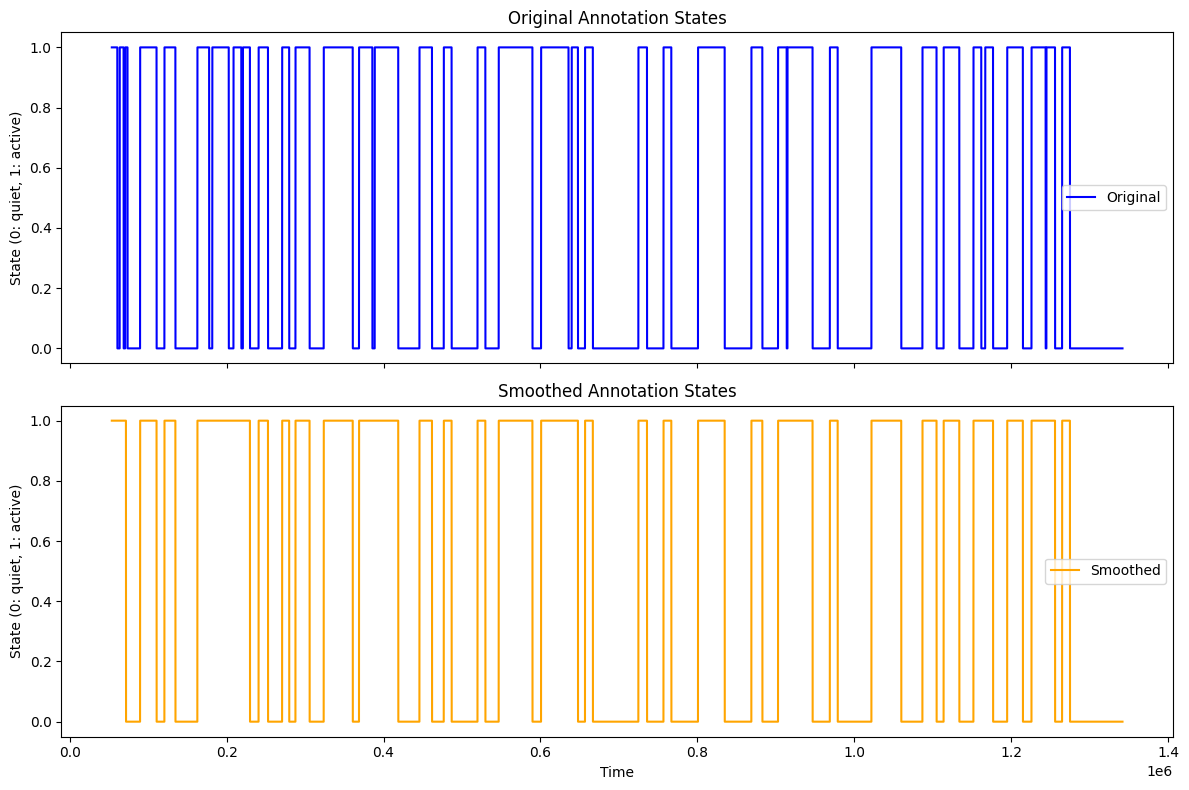

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def smooth_annotations(df, window_size=1000, threshold=0.5):
    """
    Smooth the annotation data using a rolling time-window analysis.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with columns: 'start_time', 'end_time', 'annotation'
    window_size : int, optional
        Size of the rolling window (in the same time units as the data)
    threshold : float, optional
        Threshold for deciding state (default 0.5; above threshold -> active)
        
    Returns:
    --------
    df_smoothed : pd.DataFrame
        DataFrame with the smoothed intervals and corresponding annotations.
    """
    # Work on a copy to avoid modifying the original data
    df = df.copy()
    
    # Map annotations to binary values: 0 for 'quiet', 1 for 'active'
    mapping = {'quiet': 0, 'active': 1}
    df['state'] = df['annotation'].map(mapping)
    
    # Define the time axis: we use the full range from the earliest start_time 
    # to the latest end_time. For simplicity, we convert times to integers.
    t0 = int(np.floor(df['start_time'].min()))
    t1 = int(np.ceil(df['end_time'].max()))
    time_points = np.arange(t0, t1 + 1)  # one time unit per step
    
    # Create an array to hold the state over the entire time course.
    # We assume that the intervals do not overlap.
    state_series = np.zeros(len(time_points))
    for _, row in df.iterrows():
        # Convert the times to integer indices relative to t0.
        start_idx = int(np.floor(row['start_time'])) - t0
        end_idx = int(np.ceil(row['end_time'])) - t0
        state_series[start_idx:end_idx] = row['state']
    
    # Apply a centered rolling window to smooth the state.
    state_roll = pd.Series(state_series).rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Threshold the smoothed signal to get a binary state back.
    smoothed_state = (state_roll >= threshold).astype(int)
    
    # Plot the original and smoothed annotation states.
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot original annotation
    axes[0].plot(time_points, state_series, label="Original", color='blue')
    axes[0].set_title("Original Annotation States")
    axes[0].set_ylabel("State (0: quiet, 1: active)")
    axes[0].legend()
    
    # Plot smoothed annotation
    axes[1].plot(time_points, smoothed_state, label="Smoothed", color='orange')
    axes[1].set_title("Smoothed Annotation States")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("State (0: quiet, 1: active)")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Reconstruct intervals from the smoothed binary time series.
    intervals = []
    current_state = smoothed_state.iloc[0]
    current_start = time_points[0]
    
    for i in range(1, len(time_points)):
        if smoothed_state.iloc[i] != current_state:
            intervals.append((current_start, time_points[i - 1], current_state))
            current_start = time_points[i]
            current_state = smoothed_state.iloc[i]
    # Append the final interval
    intervals.append((current_start, time_points[-1], current_state))
    
    # Create a DataFrame for the smoothed intervals and map state back to annotation.
    df_smoothed = pd.DataFrame(intervals, columns=['start_time', 'end_time', 'state'])
    inv_mapping = {0: 'quiet', 1: 'active'}
    df_smoothed['annotation'] = df_smoothed['state'].map(inv_mapping)
    df_smoothed.drop('state', axis=1, inplace=True)
    
    return df_smoothed

# Example usage:
# df = pd.read_csv("your_eye_tracking_data.csv")
df = behavior_df
df_smoothed = smooth_annotations(df, window_size=12000, threshold=0.5)
# print(df_smoothed.head())
